## Gender Classification

### Model - PCA and SVM

### Input - Images

In [3]:
import dlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [4]:
# uncomment it for your first try
# ! wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
# ! bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

In [5]:
# Read the DataFrame from the pickle file
with open('custom_dataset.pkl', 'rb') as f:
    loaded_df = pickle.load(f)

In [6]:
# Convert the list to a 2D matrix of shape (512, 512)
loaded_df['image_front_data'] = loaded_df['image_front_data'].apply(lambda x: np.array(x).reshape(512, 512))
loaded_df['image_side_data'] = loaded_df['image_side_data'].apply(lambda x: np.array(x).reshape(512, 512))

In [7]:
loaded_df.head()

,id,sex,bmi,image_front_data,image_side_data
0,A00360,Male,24.66,"[[185, 184, 183, 182, 181, 181, 181, 183, 183,...","[[180, 181, 183, 184, 186, 186, 185, 184, 183,..."
1,A00367,Male,33.23,"[[181, 183, 189, 191, 195, 200, 205, 209, 205,...","[[189, 191, 188, 194, 198, 197, 201, 211, 210,..."
2,A01815,Male,34.21,"[[165, 166, 169, 169, 169, 168, 166, 164, 164,...","[[172, 172, 171, 170, 170, 170, 170, 171, 171,..."
3,A01824,Male,28.48,"[[160, 154, 154, 155, 151, 149, 150, 153, 156,...","[[153, 153, 153, 154, 154, 153, 152, 151, 150,..."
4,A01889,Male,34.95,"[[149, 150, 151, 151, 151, 150, 150, 150, 149,...","[[153, 155, 155, 156, 158, 156, 154, 155, 156,..."


In [8]:
loaded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7663 entries, 0 to 7662
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                7663 non-null   object 
 1   sex               7662 non-null   object 
 2   bmi               7641 non-null   float64
 3   image_front_data  7663 non-null   object 
 4   image_side_data   7663 non-null   object 
dtypes: float64(1), object(4)
memory usage: 299.5+ KB


In [9]:
# Load face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [10]:
temp = pd.DataFrame()

In [11]:
labels = []

In [12]:
for i in range(len(loaded_df)):
    image = loaded_df['image_front_data'].iloc[i]

    # Detect faces
    faces = detector(image)
    
    if not faces:
        print('No face detected :',loaded_df['id'].iloc[i])
        continue

    landmarks = predictor(image, faces[0])

    if not landmarks:
        print('No landmarks detected :',loaded_df['id'].iloc[i])
        continue
        
    feature = []
    for coord in range(68):
        x_coord = landmarks.part(coord).x
        y_coord = landmarks.part(coord).y
        feature.append(x_coord)
        feature.append(y_coord)
        
    temp = pd.concat([temp, pd.DataFrame([feature])], ignore_index=True)
    if(loaded_df['sex'].iloc[i] == 'Male'):
        labels.append(0)
    else:
        labels.append(1)

No face detected : A10508
No face detected : A10938
No face detected : A80442
No face detected : A91250
No face detected : B03186
No face detected : B04516
No face detected : B09533
No face detected : B25658
No face detected : B38219
No face detected : B84769
No face detected : K74649
No face detected : M47760
No face detected : N10255
No face detected : N23774
No face detected : N62045
No face detected : N63220
No face detected : N82954
No face detected : N90809
No face detected : N93177
No face detected : N98608
No face detected : R23770
No face detected : R60484
No face detected : R68950
No face detected : Y10340
No face detected : Y22814


In [13]:
labels.count(0), labels.count(1)

(3976, 3662)

In [14]:
temp.head()

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
0,133,188,134,218,137,248,139,277,144,306,...,239,307,268,311,239,309,228,310,218,308
1,133,217,137,243,142,270,149,297,160,322,...,257,292,279,290,257,289,248,292,237,293
2,146,163,144,184,143,206,143,229,147,251,...,238,226,257,232,238,226,228,227,219,226
3,133,188,134,217,138,245,144,275,153,302,...,252,301,273,297,253,301,241,304,228,302
4,156,238,154,263,154,291,157,320,164,348,...,260,309,297,320,261,324,247,325,233,324


In [15]:
temp.shape

(7638, 136)

In [16]:
def PCA(dataset):
    mean = np.mean(dataset, axis=0)
    z = dataset - mean
    cov_matrix = (1/len(dataset)) * (z.T).dot(z)
    eig_values, eig_vectors = np.linalg.eig(cov_matrix)
    eig_pairs = [(eig_values[i], eig_vectors[:,i]) for i in range(len(eig_values))]
    eig_pairs.sort(key=lambda x: x[0], reverse=True)

    sorted_eigvalues = [eig_pairs[i][0] for i in range(len(eig_values))]
    sorted_eigvectors = np.array([eig_pairs[i][1] for i in range(len(eig_values))])

    cumulative_variance = np.cumsum(sorted_eigvalues) / np.sum(sorted_eigvalues)
    plt.plot(cumulative_variance)
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Variance')
    plt.title('Cumulative Variance vs Number of Principal Components')
    plt.show()

    n_components = np.argmax(cumulative_variance > 0.99) + 1

    print('Number of Principal Components required:', n_components)

    W = sorted_eigvectors[:, :20]
    print('Shape of W:', W.shape)

    dataset_pca = z.dot(W)
    print('Shape of Reduced Dataset:', dataset_pca.shape)
    return W, dataset_pca, mean

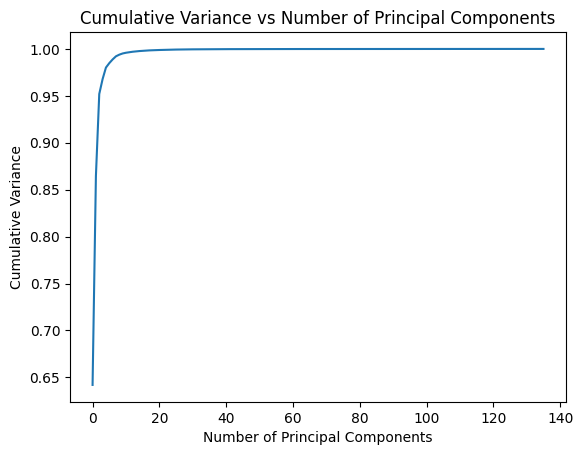

Number of Principal Components required: 8
Shape of W: (136, 20)
Shape of Reduced Dataset: (7638, 20)


In [17]:
W, dataset_reduced, mean = PCA(np.array(temp))

In [18]:
# perform svm on the reduced dataset and labels

X_train, X_test, y_train, y_test = train_test_split(dataset_reduced, labels, test_size=0.2, random_state=42)

clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.868455497382199


In [1]:
# perform svm on the original dataset and labels
X_train, X_test, y_train, y_test = train_test_split(temp, labels, test_size=0.2, random_state=42)

clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

NameError: name 'train_test_split' is not defined

In [30]:
#count no of 0 and 1 in y_pred
yppp = list(y_pred)
yppp.count(0), yppp.count(1)


(792, 736)

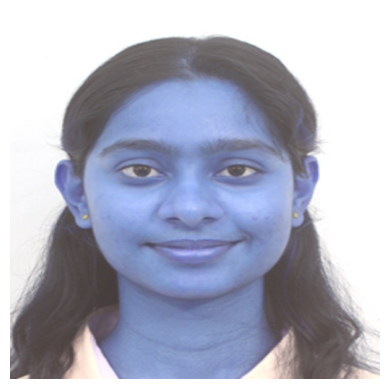

In [ ]:
# load new data as photo.jpg
import cv2
image = cv2.imread('photo.jpg')
image = cv2.resize(image, (512, 512))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image)
plt.axis('off')
plt.show()

In [20]:
faces = detector(gray)
landmarks = predictor(gray, faces[0])

feature = []
for coord in range(68):
    x_coord = landmarks.part(coord).x
    y_coord = landmarks.part(coord).y
    feature.append(x_coord)
    feature.append(y_coord)

feature = np.array(feature).reshape(1, -1)
feature = feature - mean
feature_pca = feature.dot(W)

prediction = clf.predict(feature_pca)
if prediction == 0:
    print('Male')
else:
    print('Female')

Female


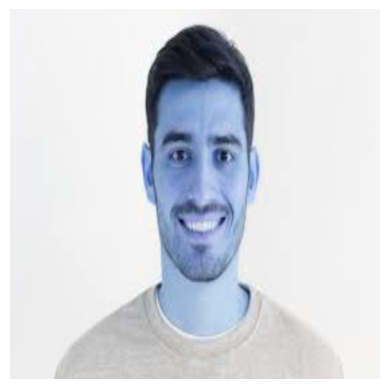

In [35]:
image = cv2.imread('he.jpeg')
image = cv2.resize(image, (512, 512))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image)
plt.axis('off')
plt.show()

In [36]:
faces = detector(gray)
landmarks = predictor(gray, faces[0])

feature = []
for coord in range(68):
    x_coord = landmarks.part(coord).x
    y_coord = landmarks.part(coord).y
    feature.append(x_coord)
    feature.append(y_coord)

feature = np.array(feature).reshape(1, -1)
feature = feature - mean
feature_pca = feature.dot(W)

prediction = clf.predict(feature_pca)
print(prediction)
if prediction == 0:
    print('Male')
else:
    print('Female')

[1]
Female
